In [ ]:
! pip install 'git+https://github.com/facebookresearch/sam2.git'

  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-gyte3zny
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-gyte3zny
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=473729 sha256=f7878c376d5eeeb15571d219a279ceb5aa27173b9d77f446c7acb2ae67935d6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ydbrptiy/wheels/25/a3/8a/abd69dc6a6926b5e75c24810afac36c7b49b5c0f8a100147d6
  Created wheel for iopath: filename=iopath-0.1.10-py3-non

In [ ]:
!mkdir -p videos
!wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
!unzip -d videos videos/bedroom.zip

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [ ]:
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import imageio

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  devide = torch.device("cpu")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3),  np.array([0.6])], axis=0)
  else:
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
video_dir = "./videos/bedroom"

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]

print(frame_names)

frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print(frame_names)

['00016.jpg', '00072.jpg', '00050.jpg', '00051.jpg', '00160.jpg', '00045.jpg', '00004.jpg', '00081.jpg', '00156.jpg', '00165.jpg', '00083.jpg', '00150.jpg', '00199.jpg', '00024.jpg', '00042.jpg', '00141.jpg', '00074.jpg', '00076.jpg', '00182.jpg', '00095.jpg', '00196.jpg', '00087.jpg', '00162.jpg', '00161.jpg', '00065.jpg', '00044.jpg', '00151.jpg', '00064.jpg', '00022.jpg', '00090.jpg', '00129.jpg', '00167.jpg', '00030.jpg', '00000.jpg', '00077.jpg', '00015.jpg', '00008.jpg', '00189.jpg', '00023.jpg', '00152.jpg', '00126.jpg', '00027.jpg', '00132.jpg', '00062.jpg', '00088.jpg', '00040.jpg', '00097.jpg', '00134.jpg', '00047.jpg', '00026.jpg', '00180.jpg', '00099.jpg', '00029.jpg', '00110.jpg', '00173.jpg', '00192.jpg', '00017.jpg', '00170.jpg', '00137.jpg', '00113.jpg', '00135.jpg', '00143.jpg', '00163.jpg', '00144.jpg', '00183.jpg', '00172.jpg', '00112.jpg', '00031.jpg', '00039.jpg', '00007.jpg', '00140.jpg', '00012.jpg', '00128.jpg', '00034.jpg', '00105.jpg', '00078.jpg', '00058.jpg'

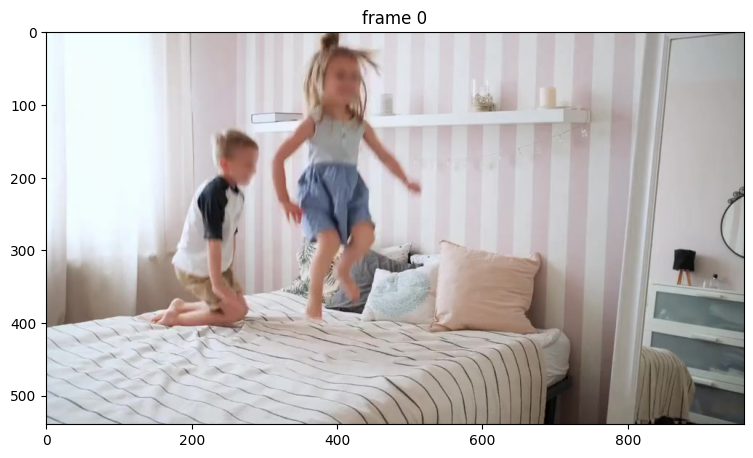

In [ ]:
# look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)
inference_state

frame loading (JPEG): 100%|██████████| 200/200 [00:06<00:00, 30.54it/s]


{'images': tensor([[[[ 1.7180,  1.8550,  1.8379,  ..., -0.3369, -0.3883, -0.4054],
           [ 1.7694,  1.9064,  1.8893,  ..., -0.3027, -0.3369, -0.3541],
           [ 1.8379,  1.9749,  1.9578,  ..., -0.2342, -0.2171, -0.2171],
           ...,
           [ 1.1700,  1.1700,  1.1529,  ..., -1.3130, -1.3130, -1.3302],
           [ 1.1529,  1.1529,  1.1529,  ..., -1.3130, -1.3302, -1.3473],
           [ 1.1529,  1.1529,  1.1529,  ..., -1.3130, -1.3302, -1.3473]],
 
          [[ 2.1660,  2.3060,  2.2885,  ..., -0.1099, -0.1625, -0.1800],
           [ 2.2185,  2.3410,  2.3410,  ..., -0.0749, -0.1099, -0.1275],
           [ 2.2885,  2.4111,  2.4111,  ..., -0.0049,  0.0126,  0.0126],
           ...,
           [ 1.4832,  1.4832,  1.4657,  ..., -1.1078, -1.1078, -1.1253],
           [ 1.4657,  1.4657,  1.4657,  ..., -1.1078, -1.1253, -1.1429],
           [ 1.4657,  1.4657,  1.4657,  ..., -1.1078, -1.1253, -1.1429]],
 
          [[ 2.3786,  2.5180,  2.5006,  ...,  0.1128,  0.0605,  0.0431],
   

In [ ]:
predictor.reset_state(inference_state)

In [ ]:
ann_frame_idx = 0 # the frame index we interact with
ann_obj_id = 1 # give a unique id to each object we interact with (it can be any integers)

# Add positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels. 1 means positive click and 0 negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

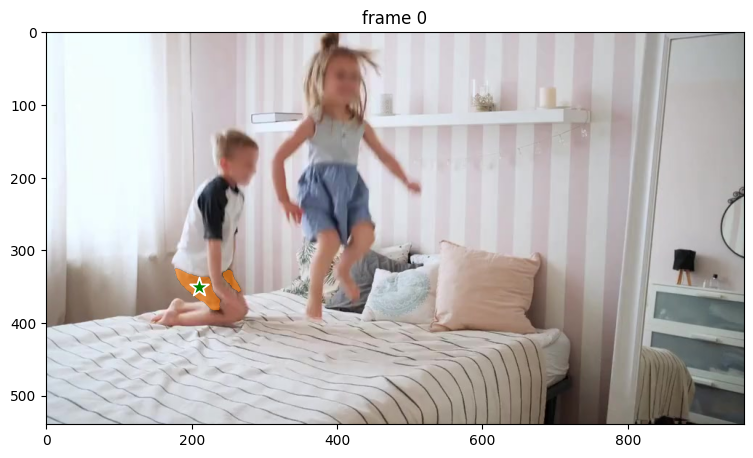

In [ ]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[210, 350], [250, 220]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

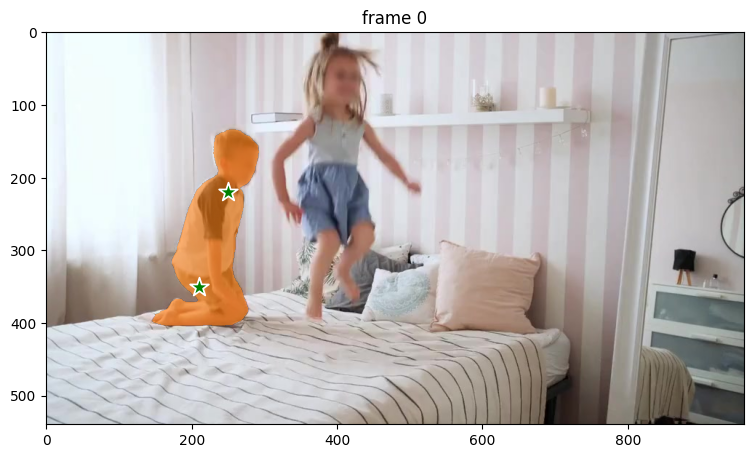

In [ ]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# run propagation throughout the video and collec the results in a dict
video_segments = {} # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
  video_segments[out_frame_idx] = {
      out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
      for i, out_obj_id in enumerate(out_obj_ids)
  }
video_segments

propagate in video: 100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


{0: {1: array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]])},
 1: {1: array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]])},
 2: {1: array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, 

In [ ]:
# ==============================================================================
# SECTION 1: Generate WebM with Transparent Background for the Object
# ==============================================================================
print("Starting the process for the object video (transparent background)...")

# Create a list to store the frames with transparent backgrounds
rgba_frames_object = []

# Iterate through all the frames that have been processed
for frame_idx in sorted(video_segments.keys()):
    # Open the original frame
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    original_frame = Image.open(frame_path).convert("RGBA")
    original_frame_np = np.array(original_frame)

    # Create a combined mask for the current frame
    h, w, _ = original_frame_np.shape
    combined_mask = np.zeros((h, w), dtype=np.uint8)

    # Add each object's mask to the combined mask
    for obj_id, mask in video_segments[frame_idx].items():
        combined_mask = np.maximum(combined_mask, (mask * 255).astype(np.uint8))

    # Create a new RGBA image for the masked object
    # Start with a fully transparent image
    rgba_frame = np.zeros_like(original_frame_np)

    # Copy the original pixel values where the mask is present
    rgba_frame[:, :, :3] = original_frame_np[:, :, :3]

    # Set the alpha channel based on the combined mask
    rgba_frame[:, :, 3] = combined_mask

    rgba_frames_object.append(rgba_frame)

# Save the RGBA frames as a WebM video with a transparent background
output_object_path = "output_transparent_object.webm"
writer_object = imageio.get_writer(output_object_path, fps=30, codec='libvpx-vp9', pixelformat='rgba')

for frame in rgba_frames_object:
    writer_object.append_data(frame)

writer_object.close()
print(f"Transparent object WebM video saved to {output_object_path}")

Starting the process for the object video (transparent background)...


Transparent object WebM video saved to output_transparent_object.webm


In [ ]:

# ==============================================================================
# SECTION 2: Generate WebM with the Object Removed (Transparent Hole)
# ==============================================================================
print("\nStarting the process for the inverse video (showing background)...")

# Create a list to store the frames with the transparent object
inverse_rgba_frames = []

# Iterate through all the frames that have been processed
for frame_idx in sorted(video_segments.keys()):
    # Open the original frame
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    original_frame = Image.open(frame_path).convert("RGBA")
    original_frame_np = np.array(original_frame)

    # Create a combined mask for the current frame
    h, w, _ = original_frame_np.shape
    combined_mask = np.zeros((h, w), dtype=np.uint8)

    # Add each object's mask to the combined mask
    for obj_id, mask in video_segments[frame_idx].items():
        combined_mask = np.maximum(combined_mask, (mask * 255).astype(np.uint8))

    # Invert the mask: background is opaque (255), object is transparent (0)
    inverse_mask = 255 - combined_mask

    # Create a new RGBA image for the masked background
    # Start with a copy of the original frame
    inverse_rgba_frame = original_frame_np.copy()

    # Set the alpha channel based on the inverse mask
    inverse_rgba_frame[:, :, 3] = inverse_mask

    inverse_rgba_frames.append(inverse_rgba_frame)

# Save the inverse RGBA frames as a new WebM video
output_inverse_path = "output_transparent_background.webm"
writer_inverse = imageio.get_writer(output_inverse_path, fps=30, codec='libvpx-vp9', pixelformat='rgba')

# Corrected the variable name from 'Aframe' to 'frame' in the loop
for frame in inverse_rgba_frames:
    writer_inverse.append_data(frame)

writer_inverse.close()

print(f"Transparent background WebM video saved to {output_inverse_path}")


Starting the process for the inverse video (showing background)...


Transparent background WebM video saved to output_transparent_background.webm
